In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import sys
import time
from collections import namedtuple, defaultdict
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cPickle as pickle

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

import logging
from logging import info


import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
RANDOM_SEED = 10000
NN_SEED = 1234
random.seed(RANDOM_SEED)

MAX_TERMS = 10000

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
NN_PARAMETER_SEARCH_PREFIX = "nn_bow_{}_batch_{}_nn_parameter_searches.pkl"

In [7]:
SAMPLE_RATIO = 0.15

In [9]:
root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_bow_parameter_search_extended_manual_batch")

training_file = root_location + "docs_output.json"

classifications_index_file = exports_location + "classifications_index.pkl"
doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list_" + str(SAMPLE_RATIO) + ".pkl"

In [10]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_label_data(classifications, doc_ids, doc_classification_map):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    data_labels = []
    for i, doc_id in enumerate(doc_ids):
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        data_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
        #if i % 1000 == 0: info(i)
    data_labels = np.array(data_labels, dtype=np.int8)
    return data_labels

In [11]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do, second_hidden_dropout_do=False):
    
    doc_input = Input(shape=(input_size,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    if second_hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [12]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 16.8 s, sys: 988 ms, total: 17.8 s
Wall time: 17.8 s


In [13]:
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 10,
    'classes': 15,
    'subclasses': 15
}
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [14]:
class MetricsCallbackWithGenerator(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallbackWithGenerator.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallbackWithGenerator.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallbackWithGenerator.GRAPH_MIN, MetricsCallbackWithGenerator.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict_generator(generator=nn_batch_generator_no_shuffle(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0])
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [15]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(shuffle_index)
    X_data =  X_data[shuffle_index, :]
    y_data =  y_data[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [16]:
def nn_batch_generator_no_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0

In [24]:
def nn_batch_generator_sample(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(shuffle_index)
    X_data =  X_data[shuffle_index, :]
    y_data =  y_data[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
#         X_batch = X_data[index_batch,:].todense()
#         y_batch = y_data[index_batch]
        counter += 1
        yield index_batch
        if (counter > number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [35]:
def nn_batch_generator_sample_no_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
#         X_batch = X_data[index_batch,:].todense()
#         y_batch = y_data[index_batch]
        counter += 1
        yield index_batch
        if (counter > number_of_batches):
            counter=0

In [30]:
X_sample = np.zeros((100,20))
y_sample = np.zeros(100)
gen = nn_batch_generator_sample(X_sample, y_sample, 12)
for i,d in enumerate(gen):
    if i> 20:
        break
    print d

[78 76 18 32 54 66 96 94 91 60 59 16]
[95 99 64 81 38 28 53 68 71 13 25 10]
[20 69 14 49 39 29 24 40 12  7 98  1]
[ 3 57 42 50 55  6 22 11 33 84 21 37]
[93 86 79 17 80 75 15  0  2 89 35 63]
[56 31 48 62 46 47 52 27 73 44 90 97]
[92 41 83 70 34 85 74 77 65 61 88 45]
[82 58 43 67 30 23 72 36 51  4  9  8]
[19 26  5 87]
[70 27 54 42 98 15 13 51 32 31 87 76]
[61 28  2  6 94 58 73 40  8 86 14 33]
[ 3 77 53 10 23 80 50 55 93 22 67 78]
[21 43 20  7 64 24 79 19 63 29 52 91]
[11 90 81 82 84 71  5 41 35  0 45 34]
[66 36 68 62 38 18 30 17 69 74 37 48]
[92 99 56  4 47 46 59 12 85 89 57 25]
[95 88 39 97 26 49 60 83 16 96 65  9]
[ 1 75 72 44]
[64  7 59 39 11 38 75 87 20  5  3 19]
[92 22 78 85 27 88 25 56  2  0 69 73]
[26 94 71 66 31 37 74 49 48 61 80 35]


In [36]:
X_sample = np.zeros((100,20))
y_sample = np.zeros(100)
gen = nn_batch_generator_sample_no_shuffle(X_sample, y_sample, 12)
for i,d in enumerate(gen):
    if i> 20:
        break
    print d

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77 78 79 80 81 82 83]
[84 85 86 87 88 89 90 91 92 93 94 95]
[96 97 98 99]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77 78 79 80 81 82 83]
[84 85 86 87 88 89 90 91 92 93 94 95]
[96 97 98 99]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30 31 32 33 34 35]


## Training and Validation Loop

In [19]:
classifications = sections
classifications_type = "sections"

In [22]:
NN_OUTPUT_NEURONS = len(classifications)
# NN_INPUT_NEURONS = DOC2VEC_SIZE

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 30
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 2048

MODEL_VERBOSITY = 1

to_skip = []

load_existing_results = False
save_results = False


first_hidden_layer_sizes = [100,200,500,1000]
# first_hidden_layer_sizes = [1000,2000]
# second_hidden_layer_sizes = [1000,2000,3000,4000]
second_hidden_layer_sizes = [None,500,1000,2000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False, True]
# hidden_dropout_options = [False, True]
input_dropout_options = [False]
hidden_dropout_options = [True]
second_hidden_dropout_options = [False]


np.random.seed(NN_SEED)


# Uncomment for Specific Configuration
# NN_RANDOM_SEARCH_BUDGET = 1
# first_hidden_layer_sizes = [500]
# second_hidden_layer_sizes = [2000]
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False]
# hidden_dropout_options = [True]
# second_hidden_dropout_options = [False]

In [23]:
%matplotlib notebook

2017-04-03 01:01:59,691 : INFO : =============== bm25 Being Evaluated ================
2017-04-03 01:01:59,692 : INFO : ***************************************************************************************
2017-04-03 01:01:59,693 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           5000500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          1002000     dropout_2[0][0]                  
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


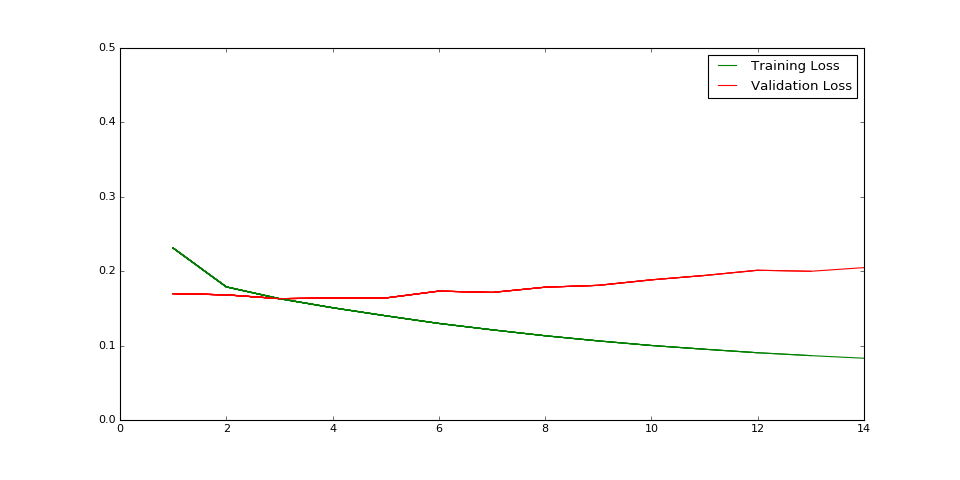

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2313

2017-04-03 01:02:18,641 : INFO : Found lower val loss for epoch 1 => 0.16988


254767/254767 [==============================] - 17s - loss: 0.2311 - val_loss: 0.1699
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1790

2017-04-03 01:02:34,610 : INFO : Found lower val loss for epoch 2 => 0.16822


254767/254767 [==============================] - 15s - loss: 0.1789 - val_loss: 0.1682
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1632

2017-04-03 01:02:51,213 : INFO : Found lower val loss for epoch 3 => 0.16313


254767/254767 [==============================] - 16s - loss: 0.1631 - val_loss: 0.1631
Epoch 4/200
254767/254767 [==============================] - 16s - loss: 0.1509 - val_loss: 0.1638
Epoch 5/200
254767/254767 [==============================] - 16s - loss: 0.1401 - val_loss: 0.1640
Epoch 6/200
254767/254767 [==============================] - 16s - loss: 0.1298 - val_loss: 0.1733
Epoch 7/200
254767/254767 [==============================] - 16s - loss: 0.1212 - val_loss: 0.1715
Epoch 8/200
254767/254767 [==============================] - 16s - loss: 0.1132 - val_loss: 0.1785
Epoch 9/200
254767/254767 [==============================] - 16s - loss: 0.1063 - val_loss: 0.1810
Epoch 10/200
254767/254767 [==============================] - 15s - loss: 0.1001 - val_loss: 0.1884
Epoch 11/200
254767/254767 [==============================] - 16s - loss: 0.0951 - val_loss: 0.1943
Epoch 12/200
254767/254767 [==============================] - 17s - loss: 0.0904 - val_loss: 0.2013
Epoch 13/200
254767

2017-04-03 01:05:53,476 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00013: early stopping
CPU times: user 3min 14s, sys: 3min 55s, total: 7min 10s
Wall time: 3min 53s


2017-04-03 01:05:57,043 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.501 | Top 3: 0.963 | Top 5: 0.993 | F1 Micro: 0.766 | F1 Macro: 0.671
CPU times: user 3min 19s, sys: 3min 59s, total: 7min 18s
Wall time: 3min 59s


In [43]:
%%time
data_types = ["bm25"]
# data_types = ["tf"]
for data_type in data_types:
    info("=============== {} Being Evaluated ================".format(data_type))
    
    GLOBAL_VARS.MODEL_NAME = data_type + "/size_{}".format(MAX_TERMS)
    
    data_training_location = exports_location + "extended_pv_benchmarking_data/" + "{}_training_sparse_data.pkl".format(data_type)
    data_training_docids_location = exports_location + "extended_pv_benchmarking_data/" + "{}_training_sparse_docids.pkl".format(data_type)
    data_validation_location = exports_location + "extended_pv_benchmarking_data/" + "{}_validation_sparse_data.pkl".format(data_type)
    data_validation_docids_location = exports_location + "extended_pv_benchmarking_data/" + "{}_validation_sparse_docids.pkl".format(data_type)
    
#     # Get the training data
#     info('Getting Training Data')
#     %time X = pickle.load(open(data_training_location, "r"))
#     training_data_docids = pickle.load(open(data_training_docids_location, "r"))
#     %time y = get_label_data(classifications, training_data_docids, doc_classification_map)
    
#     print X.shape
#     print y.shape

#     # Get the validation data
#     info('Getting Validation Data')
#     %time Xv = pickle.load(open(data_validation_location,'r'))
#     validation_data_docids = pickle.load(open(data_validation_docids_location, "r"))
#     %time yv = get_label_data(classifications, validation_data_docids, doc_classification_map)
    
    NN_INPUT_NEURONS = X.shape[1]


    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options,
        'second_hidden_dropout':second_hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

    param_results_dict = {}

    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))

    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results in {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    for parameters in param_sampler:
        start_time = time.time()
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        second_hidden_dropout_do = parameters['second_hidden_dropout']

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )
        if second_hidden_dropout_do:
            GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

        if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
            print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
            continue
    #         if first_hidden_layer_size < DOC2VEC_SIZE or second_hidden_layer_size < NN_OUTPUT_NEURONS:
    #             print "skipping: {} due to 1st layer size {} < {} or 2nd layer size {} < {}".format(GLOBAL_VARS.NN_MODEL_NAME,
    #                                                                                                 first_hidden_layer_size, DOC2VEC_SIZE, 
    #                                                                                                 second_hidden_layer_size, NN_OUTPUT_NEURONS)
    #             continue


        info('***************************************************************************************')
        info(GLOBAL_VARS.NN_MODEL_NAME)

        model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do, second_hidden_dropout_do)
        model.summary()

        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                      patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
        metrics_callback = MetricsCallbackWithGenerator()

        # Model Fitting
#         %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
#                                   nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, callbacks=[early_stopper, metrics_callback])

        %time history = model.fit_generator(generator=nn_batch_generator_no_shuffle(X, y, NN_BATCH_SIZE), \
                                            samples_per_epoch=X.shape[0],\
                                            validation_data=nn_batch_generator_no_shuffle(Xv, yv, NN_BATCH_SIZE),\
                                            nb_val_samples=Xv.shape[0],\
                                            nb_epoch=NN_MAX_EPOCHS, callbacks=[early_stopper, metrics_callback])

        # using the recorded weights of the best recorded validation loss
        last_model_weights = model.get_weights()
        info('Evaluating on Validation Data using saved best weights')
        model.set_weights(metrics_callback.best_weights)
        yvp = model.predict_generator(generator=nn_batch_generator_no_shuffle(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0])
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
            validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'])
        best_validation_metrics = validation_metrics
        time.sleep(0.2)

        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

        duration = time.time() - start_time
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

        del history, last_model_weights, metrics_callback

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))
    #del X, Xv